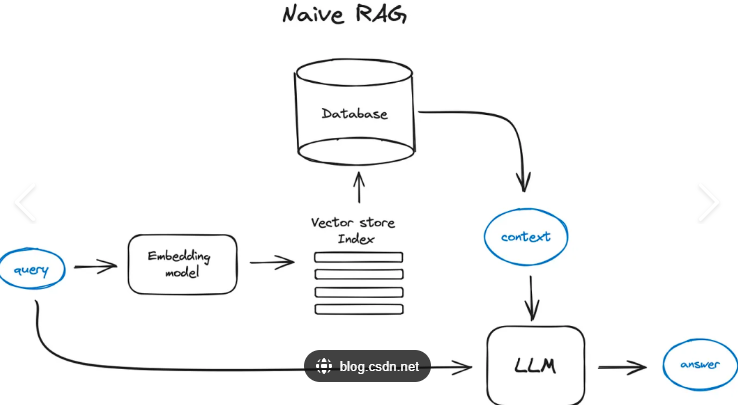

# hide all warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Loading the pdf pages

In [188]:
from langchain_community.document_loaders import PyPDFLoader

# Ask user to enter PDF path
file_path = input("Enter the path to your PDF file: ")

# Load PDF
loader = PyPDFLoader(file_path)

pages=[]
for doc in loader.lazy_load():
    pages.append(doc)
    
print(f"Loaded {len(pages)} pages.")


Loaded 20 pages.


## watching the pages

In [172]:
pages[:2]

[Document(metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2024-12-04T11:57:21+05:45', 'author': 'Sakchyam Thapa', 'moddate': '2024-12-04T11:57:21+05:45', 'source': 'net.pdf', 'total_pages': 20, 'page': 0, 'page_label': '1'}, page_content='Module Code & Module Title  \nCS6P05NI Final Year Project  \n5% FYP Proposal  \nSemester  \n2024 Autumn  \nPROJECT TITLE: Sonic Points \nStudent Name: Sakchyam Thapa  \nLondon Met ID: 22067800  \nCollege ID: np01cp4a220185@islingtoncollege.edu.np  \nInternal Supervisor: Dipesh Raj Adhikari  \nExternal Supervisor: Abhishek Rokaya  \nAssignment Due Date: 2024/12/4 \nAssignment Submission Date: 2024/12/4 \n  \n  \nI confirm that I understand my coursework needs to be submitted online via Google Classroom under \nthe relevant module page before the deadline for my assignment to be accepted and marked. I am \nfully aware that late submissions will be treated as non-submission and a mark of zero will be \naw

In [173]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size =500,
    chunk_overlap = 200
)

chunk_text=text_splitter.split_documents(pages)

page_content=[doc.page_content for doc in chunk_text]

print(f"embeded vectors:{len(page_content)}")


embeded vectors:62


## loading the embeddings model

In [174]:
from sentence_transformers import SentenceTransformer

from dotenv import load_dotenv

load_dotenv()

model = SentenceTransformer("all-mpnet-base-v2")
embedding = model.encode(page_content)
print(f"embedding size:{len(embedding)}")

embedding size:62


# making vector database

In [176]:
from pinecone import Pinecone
from pinecone import ServerlessSpec
import os
from dotenv import load_dotenv
import time

load_dotenv()


pc =Pinecone(os.getenv("pine"),ssl_verify=False)

index_name="mcp-index" # its like database name

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

    print("Index created successfully")

else:
    print("Index already exist")

while not pc.describe_index(index_name).status["ready"]:
    time.sleep(1)                                       




Index already exist


## putting vectors and text in vector database

In [177]:
index=pc.Index(index_name)
records=[]
for i,(d,e) in enumerate(zip(page_content,embedding)):
    records.append(
        {
            "id":f"chunk_{i}",
            "values" : e,
            "metadata" : {"text" : d}

        }
    )

index.upsert(
    vectors=records,
    namespace="391104eng" #its like table name
)

UpsertResponse(upserted_count=62, _response_info={'raw_headers': {'date': 'Wed, 03 Dec 2025 16:44:41 GMT', 'content-type': 'application/json', 'content-length': '20', 'connection': 'keep-alive', 'x-pinecone-request-lsn': '5', 'x-pinecone-request-logical-size': '217807', 'x-pinecone-request-latency-ms': '2148', 'x-pinecone-request-id': '2764321892112112821', 'x-envoy-upstream-service-time': '242', 'grpc-status': '0', 'server': 'envoy'}})

# quering into index

In [178]:
index=pc.Index(index_name)


In [179]:
def query_index(pc, embedding_model, query: str, index_name: str, namespace: str, k: int = 5, ):

    if embedding_model is None:
        raise ValueError("Embedding model must be provided")

    # Create index object
    index = pc.Index(index_name)

    # Create embedding for query
    query_embedding = embedding_model.encode(query).tolist()
    
    # Query Pinecone
    result = index.query(
        namespace=namespace,
        vector=query_embedding,
        top_k=k,
        include_metadata=True,
        include_values=True
    )

    return result


## collecting all the retrival results and combing into single text

In [180]:
question=input("What your question?")
ans=query_index(pc=pc,embedding_model=model,index_name=index_name,namespace="391104eng",query=question)

In [181]:

all_text = ""

for match in ans.matches:
    # Get the text from metadata and append
    all_text += match['metadata']['text'] + " "  # add space between chunks


In [183]:
print(all_text)

discover their pain points and sort out the features they need. 
o Place these tasks in the Kanban board for maximum visibility and 
adherence to progress. 
 
 
❖ Planning 
❖ Goal: Establish the project Scope, Timeline, and the Development Resources. 
❖  Activities: 
o Develop project milestones and deliverables. 
o Use the Kanban board to organize tasks according to priority and add 
due dates. 
o Make sure that the Kanban board represents the flow of tasks (e.g., o Use the Kanban board to organize tasks according to priority and add 
due dates. 
o Make sure that the Kanban board represents the flow of tasks (e.g., 
"Backlog," "In Progress," "Completed"). CS6P05NI                                                                    Final Year Project  
8 | P a g e 
 
5. Methodology:  
5.1. Kanban Methodology:   
  
The Kanban methodology will be utilized in the development of the Task Management 
Application emphasizing flexibility, continuous delivery and visual management. These 
task

# giving retrival output to model

In [186]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro",api_key=os.getenv("GOOGLE_API_KEY"))

prompt=f""""i have provided you the context and the question. look the contex carefully and give the correct answer 
        for the given question. dont try to answer yourself if context doesnot have the answer simply say i am unable to
        answer. dont add any preamble.
        context:{all_text} \n
        question:{question}"""

answer=llm.invoke(prompt)

## final chatbot answer

In [187]:
print(answer.content)

The Kanban methodology is a methodology utilized in development that emphasizes flexibility, continuous delivery, and visual management. In this methodology, tasks move through stages based on their capacity.
